In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from IPython.display import display
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeRegressor
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop(["Unnamed: 0", "dealing", "cnt"], axis = 1, inplace = True)
test.drop(["Unnamed: 0", "id"], axis = 1, inplace = True)
train.columns

Index(['time_date', 'site', 'continent_id', 'buyer_country', 'buyer_region',
       'buyer_city', 'distance', 'buyer_id', 'mobile', 'package', 'channel_id',
       'buying_date', 'dealing_date', 'adults', 'children', 'room',
       'destination_id', 'destination_type', 'regency_continent',
       'regency_country', 'regency_market', 'regency_cluster'],
      dtype='object')

In [3]:
test.columns

Index(['time_date', 'site', 'continent_id', 'buyer_country', 'buyer_region',
       'buyer_city', 'distance', 'buyer_id', 'mobile', 'package', 'channel_id',
       'buying_date', 'dealing_date', 'adults', 'children', 'room',
       'destination_id', 'destination_type', 'regency_continent',
       'regency_country', 'regency_market'],
      dtype='object')

In [4]:
test.shape

(21018, 21)

In [5]:
train.shape

(343583, 22)

In [3]:
#Feature with inconsistent columns and values
features_inconsistent = ["Unnamed: 0", "id", "dealing", "cnt", "distance"]
#Feature ID 
features_int_to_cat = ["site","continent_id", "buyer_country", "buyer_region", "buyer_city",
                      "buyer_id", "mobile", "package", "channel_id", "destination_id",
                      "destination_type", "regency_continent", "regency_country", "regency_market"]
#Feature Categorical
features_nom = ["time_date","buying_date","dealing_date"]


def clean(df):
    for name in features_inconsistent:
        df.drop(name, axis = 1, inplace = True)
    return df

def encode(df):
    for name in features_int_to_cat:
        df[name] = df[name].astype("category")
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    return df

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def load_data():
    # Read data
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [53]:
#df = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv")

df_train, df_test = load_data()

#df.dtypes

In [54]:
df_train.dtypes

time_date            category
site                 category
continent_id         category
buyer_country        category
buyer_region         category
buyer_city           category
buyer_id             category
mobile               category
package              category
channel_id           category
buying_date          category
dealing_date         category
adults                  int64
children                int64
room                    int64
destination_id       category
destination_type     category
regency_continent    category
regency_country      category
regency_market       category
regency_cluster       float64
dtype: object

In [4]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSE (Root Mean Squared Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [56]:
X = df_train.copy()
y = X.pop("regency_cluster")

baseline_score = score_dataset(X, y)
print("Baseline score: ", baseline_score, " RMSE")

Baseline score:  30.980330548875017  RMSE


In [5]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

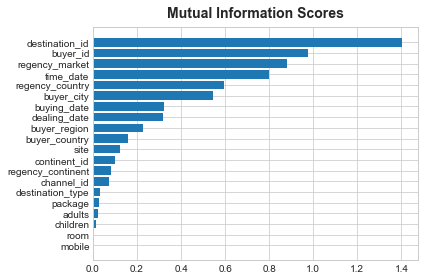

In [58]:
X = df_train.copy()
y = X.pop("regency_cluster")

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

In [6]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [60]:
X = df_train.copy()
y = X.pop("regency_cluster")
X = drop_uninformative(X, mi_scores)

mi_scores

destination_id       1.403260
buyer_id             0.977548
regency_market       0.882650
time_date            0.799332
regency_country      0.596231
buyer_city           0.542621
buying_date          0.321681
dealing_date         0.316660
buyer_region         0.226292
buyer_country        0.159221
site                 0.120894
continent_id         0.100813
regency_continent    0.081133
channel_id           0.074060
destination_type     0.030163
package              0.029659
adults               0.020915
children             0.014083
room                 0.003740
mobile               0.002705
Name: MI Scores, dtype: float64

In [7]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [8]:
#5 features dengan 5 MI tertinggi
cluster_features = [
    "destination_id",
    "buyer_id",
    "regency_market",
    "time_date",
    "regency_country",
]


def cluster_labels(df, features, n_clusters=100):
    X = df.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0, max_iter = 5)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

#X = df_train.copy()
#y = X.pop("regency_cluster")

#X = X.join(cluster_labels(X, cluster_features, n_clusters=100))

In [120]:
X.Cluster.value_counts()

64    12481
59     9128
68     8474
13     8464
0      8316
      ...  
46      725
56      657
73      644
74      497
75      402
Name: Cluster, Length: 100, dtype: int64

In [9]:
def apply_pca(X, standardize=True):
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [10]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    for colname in df.select_dtypes(["object", "category"]):
        df[colname], _ = df[colname].factorize()
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

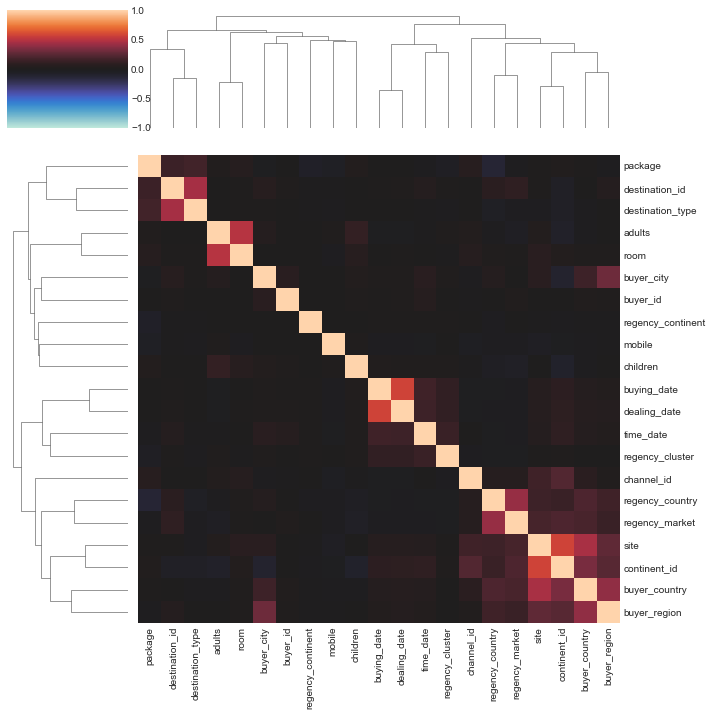

In [73]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    for colname in df.select_dtypes(["object", "category"]):
        df[colname], _ = df[colname].factorize()
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

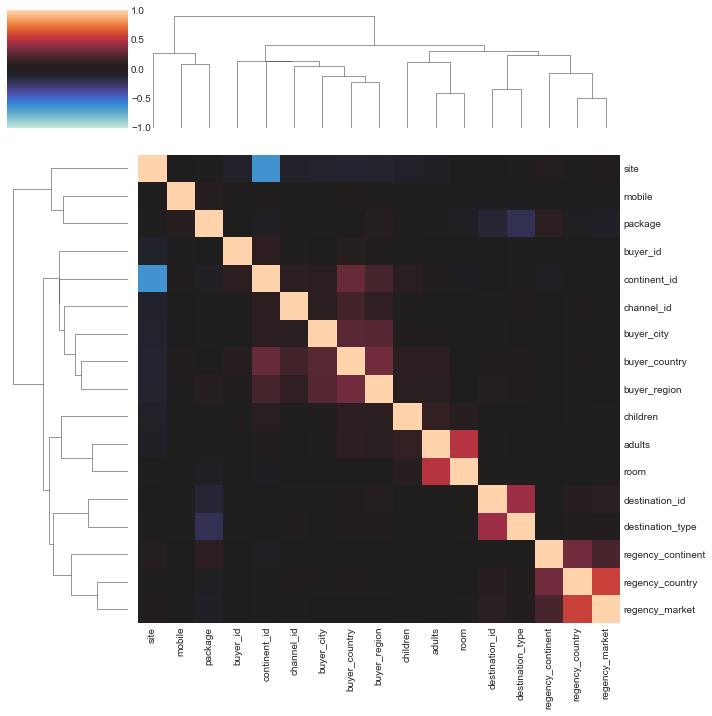

In [28]:
corrplot(X, annot = None)

In [11]:
def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [81]:
def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = ["site","continent_id", "buyer_country", "buyer_region", "buyer_city",
                "buyer_id", "mobile", "package", "channel_id", "destination_id",
                "destination_type", "regency_continent", "regency_country", "regency_market"]

pca, X_pca, loadings = apply_pca(X[pca_features])

loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
site,0.476405,-0.017187,-0.220429,-0.149645,0.099879,-0.022758,-0.057679,-0.156915,-0.186454,-0.421262,0.100674,-0.111029,-0.034178,0.653804
continent_id,0.440223,-0.100204,-0.383869,-0.033419,0.095412,-0.016430,-0.113846,-0.121036,-0.126414,-0.139013,-0.309593,-0.254513,0.140349,-0.628553
buyer_country,0.454754,0.025352,0.073544,-0.194488,0.018043,-0.072171,-0.008919,-0.190004,0.031666,0.250821,0.581315,0.466585,-0.159788,-0.250063
buyer_region,0.372063,0.075733,0.316283,-0.302915,0.003992,-0.089317,0.105449,-0.000635,0.074247,0.583552,-0.471053,-0.178045,-0.014347,0.212334
buyer_city,0.121097,0.123578,0.537960,-0.401929,-0.071279,0.033721,0.156076,0.326510,0.107032,-0.554183,-0.005664,-0.000428,0.138776,-0.209914
buyer_id,0.024345,0.033236,0.152187,-0.100526,-0.198812,0.613040,-0.732003,0.000706,-0.067332,0.077105,0.018391,-0.040458,0.031019,0.021136
mobile,-0.052540,-0.071499,0.131647,0.007244,0.367244,-0.623077,-0.618570,0.161212,0.200274,-0.032767,0.021681,-0.026103,0.019331,0.018019
package,-0.016413,0.360088,-0.351550,-0.181690,-0.239242,0.001428,-0.024812,-0.113302,0.774746,-0.024297,0.088198,-0.170637,0.062202,0.034514
channel_id,0.167955,0.009385,-0.380416,-0.016312,0.086069,0.136861,0.031990,0.865607,0.003933,0.160806,0.053566,0.121800,-0.052945,0.062460
destination_id,0.021929,0.645061,0.070280,0.168577,0.129416,-0.011203,-0.032989,0.027092,-0.177770,-0.069051,-0.007194,-0.224255,-0.655977,-0.119765


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

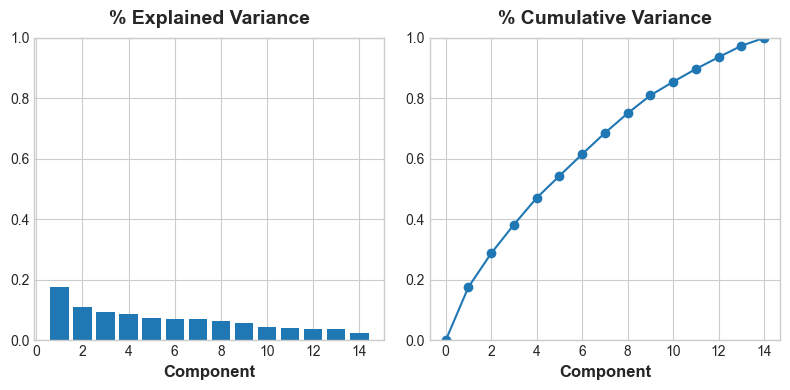

In [82]:
plot_variance(pca)

In [12]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  
        self.cv_ = KFold(n_splits=5)

    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

#X = df_train.copy()
#y = X.pop("regency_cluster")

#encoder = CrossFoldEncoder(MEstimateEncoder, m=1)

#X = X.join(encoder.fit_transform(X, y, cols=["site", "continent_id", "buyer_country", "buyer_region", "buyer_city", 
#                                               "channel_id", "destination_id", "destination_type", "regency_continent",
#                                               "regency_country", "regency_market"]))

#print("done")

In [90]:
df_train.site.nunique()

32

In [15]:
pca_features = ["site","continent_id", "buyer_country", "buyer_region", "buyer_city",
                "buyer_id", "mobile", "package", "channel_id", "destination_id",
                "destination_type", "regency_continent", "regency_country", "regency_market"]

def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("regency_cluster")
    mi_scores = make_mi_scores(X, y)

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Clustering Top 5 MI
    X = X.join(cluster_labels(X, cluster_features, n_clusters=100))
    
    # PCA ID Features
    X = X.join(pca_components(X, pca_features))
    
    X = label_encode(X)

    # Target Encoder Rare Value at Categorical Variables
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["site", "continent_id", "buyer_country", "buyer_region", "buyer_city", 
                                               "channel_id", "destination_id", "destination_type", "regency_continent",
                                               "regency_country", "regency_market"]))

    return X

In [135]:
X_train_reshape.shape

(364601, 46)

In [136]:
y_train.shape

(364601,)

In [140]:
score_dataset(X_train_reshape, y_train)

30.642856017921016

In [16]:
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "regency_cluster"]
X_train_reshape = X_train.iloc[:364601]
X_test_renew = pd.read_csv("test.csv")

In [67]:
X_train_reshape = X_train.iloc[:364601]

301547

In [68]:
id_number = np.arange(1,364602)

df_id = pd.DataFrame(id_number, columns=["id"])

In [69]:
df_id.id.nunique()

364601

In [70]:
df_id.id.tail()

364596    364597
364597    364598
364598    364599
364599    364600
364600    364601
Name: id, dtype: int32

In [72]:
X_train_reshape.shape

(364601, 47)

In [73]:
X_train_reshape["id"] = 1

In [74]:
X_train_reshape["id"] = df_id["id"]

In [77]:
X_train_reshape.shape

(364601, 47)

In [79]:
X_train_reshape.columns

Index(['time_date', 'site', 'continent_id', 'buyer_country', 'buyer_region',
       'buyer_city', 'buyer_id', 'mobile', 'package', 'channel_id',
       'buying_date', 'dealing_date', 'adults', 'children', 'room',
       'destination_id', 'destination_type', 'regency_continent',
       'regency_country', 'regency_market', 'Cluster', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12',
       'PC13', 'PC14', 'site_encoded', 'continent_id_encoded',
       'buyer_country_encoded', 'buyer_region_encoded', 'buyer_city_encoded',
       'channel_id_encoded', 'destination_id_encoded',
       'destination_type_encoded', 'regency_continent_encoded',
       'regency_country_encoded', 'regency_market_encoded', 'id'],
      dtype='object')

In [88]:
X_train_renew.dtypes

id                   int32
time_date            int32
site                  int8
continent_id          int8
buyer_country        int16
buyer_region         int16
buyer_city           int16
buyer_id             int16
mobile                int8
package               int8
channel_id            int8
buying_date          int16
dealing_date         int16
adults               int64
children             int64
room                 int64
destination_id       int16
destination_type      int8
regency_continent     int8
regency_country      int16
regency_market       int16
dtype: object

In [89]:
X_test_renew.dtypes

id                    int64
time_date            object
site                  int64
continent_id          int64
buyer_country         int64
buyer_region          int64
buyer_city            int64
buyer_id              int64
mobile                int64
package               int64
channel_id            int64
buying_date          object
dealing_date         object
adults                int64
children              int64
room                  int64
destination_id        int64
destination_type      int64
regency_continent     int64
regency_country       int64
regency_market        int64
dtype: object

In [80]:
X_train_renew = X_train_reshape[["id","time_date", "site", "continent_id", "buyer_country",
                                "buyer_region", "buyer_city", "buyer_id", "mobile", "package",
                                "channel_id", "buying_date", "dealing_date", "adults", "children",
                                "room", "destination_id", "destination_type","regency_continent",
                                "regency_country", "regency_market"]]

In [84]:
X_test_renew.drop(["Unnamed: 0", "distance"], axis = 1, inplace = True)

In [86]:
X_test_renew.shape

(21018, 21)

In [90]:
for colname in X_test_renew.select_dtypes(["object", "category"]):
        X_test_renew[colname], _ = X_test_renew[colname].factorize()

In [99]:
xgb = XGBRegressor(learning_rate = 0.05, random_state = 0)
xgb.fit(X_train_renew,y_train)
predictions = xgb.predict(X_test_renew)

In [97]:
output = pd.DataFrame({'id': X_test_renew.index, 'regency_cluster': predictions})
output.to_csv('my_submission_2.csv.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [100]:
submission = pd.read_csv("my_submission_1.csv")

In [102]:
submission.dtypes

id                   int64
regency_cluster    float64
dtype: object

In [103]:
submission["regency_cluster"] = submission["regency_cluster"].astype("int64")

In [104]:
submission.dtypes

id                 int64
regency_cluster    int64
dtype: object

In [106]:
submission.regency_cluster.nunique()

46

In [123]:
df_train[df_train["regency_cluster"] == 26.0].head(8)

,time_date,site,continent_id,buyer_country,buyer_region,buyer_city,buyer_id,mobile,package,channel_id,...,dealing_date,adults,children,room,destination_id,destination_type,regency_continent,regency_country,regency_market,regency_cluster
76,2/16/2013 12:03,2,3,66,462,41898,1482,0,0,0,...,3/1/2013,2,0,1,8857,1,1,2,50,26.0
110,10/10/2014 17:18,2,3,66,462,41898,1482,0,1,0,...,4/7/2015,2,0,1,8855,1,3,2,50,26.0
835,9/15/2014 17:46,13,1,46,171,19639,4539,0,1,9,...,9/26/2014,2,0,1,468,1,2,3,48,26.0
1044,12/11/2014 10:50,11,3,205,354,25315,6450,0,1,5,...,1/2/2015,2,0,1,8284,1,1,2,50,26.0
1180,9/29/2014 7:28,2,3,66,311,33705,6929,1,1,9,...,4/13/2015,2,0,1,11334,1,1,4,96,26.0
1444,12/26/2013 13:09,2,3,66,174,21356,7523,1,1,9,...,4/6/2014,4,0,2,8791,1,1,4,8,26.0
1486,8/8/2014 23:02,2,3,66,174,21356,7523,1,1,9,...,5/12/2015,6,0,3,11373,1,1,4,128,26.0
1609,7/31/2014 17:14,2,3,215,646,51733,7573,0,0,9,...,9/27/2014,6,0,1,11938,1,1,4,8,26.0


In [111]:
submission.regency_cluster.unique()

array([23, 26, 25, 27, 29, 28, 24, 30, 31, 35, 33, 32, 22, 21, 19, 20, 49,
       45, 47, 51, 50, 55, 48, 53, 46, 54, 52, 56, 44, 43, 60, 59, 64, 58,
       57, 61, 62, 41, 65, 63, 42, 40, 39, 38, 34, 37], dtype=int64)

In [118]:
submission[submission["regency_cluster"] == 26].head(5)

,id,regency_cluster
1,1,26
5,5,26
6,6,26
10,10,26
17,17,26


In [119]:
X_test_renew[X_test_renew["id"] == 10]

,id,time_date,site,continent_id,buyer_country,buyer_region,buyer_city,buyer_id,mobile,package,...,buying_date,dealing_date,adults,children,room,destination_id,destination_type,regency_continent,regency_country,regency_market
10,10,10,2,3,66,311,48189,51,0,0,...,9,10,2,0,1,12267,6,2,50,1230


In [120]:
X_test_renew[X_test_renew["id"] == 17]

,id,time_date,site,continent_id,buyer_country,buyer_region,buyer_city,buyer_id,mobile,package,...,buying_date,dealing_date,adults,children,room,destination_id,destination_type,regency_continent,regency_country,regency_market
17,17,17,2,3,57,342,5021,57,0,0,...,15,14,3,1,1,12008,1,2,50,686


In [121]:
X_test_renew[X_test_renew["id"] == 6]

,id,time_date,site,continent_id,buyer_country,buyer_region,buyer_city,buyer_id,mobile,package,...,buying_date,dealing_date,adults,children,room,destination_id,destination_type,regency_continent,regency_country,regency_market
6,6,6,2,3,66,311,48189,51,0,0,...,5,6,2,0,1,8271,1,2,50,696


In [122]:
output = pd.DataFrame({'id': submission.id, 'regency_cluster': submission.regency_cluster})
output.to_csv('my_submission_final.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
